In [0]:
# Credits: https://github.com/SullyChen/Autopilot-TensorFlow
# Research paper: End to End Learning for Self-Driving Cars by Nvidia. [https://arxiv.org/pdf/1604.07316.pdf]

# NVidia dataset: 72 hrs of video => 72*60*60*30 = 7,776,000 images
# Nvidia blog: https://devblogs.nvidia.com/deep-learning-self-driving-cars/


# Our Dataset: https://github.com/SullyChen/Autopilot-TensorFlow [https://drive.google.com/file/d/0B-KJCaaF7elleG1RbzVPZWV4Tlk/view]
# Size: 25 minutes = 25*60*30 = 45,000 images ~ 2.3 GB


# If you want to try on a slightly large dataset: 70 minutes of data ~ 223GB
# Refer: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5
# Format: Image, latitude, longitude, gear, brake, throttle, steering angles and speed



# Additional Installations:
# pip3 install h5py


# AWS: https://aws.amazon.com/blogs/machine-learning/get-started-with-deep-learning-using-the-aws-deep-learning-ami/

# Youtube:https://www.youtube.com/watch?v=qhUvQiKec2U
# Further reading and extensions: https://medium.com/udacity/teaching-a-machine-to-steer-a-car-d73217f2492c
# More data: https://medium.com/udacity/open-sourcing-223gb-of-mountain-view-driving-data-f6b5593fbfa5

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!pip install pyunpack
!pip install patool
!pip install imgaug==0.2.5

!pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 2.0MB/s 
  Found existing installation: scipy 1.3.1
    Uninstalling scipy-1.3.1:
      Successfully uninstalled scipy-1.3.1


In [0]:
from pyunpack import Archive
Archive('drive/My Drive/CoLab/Self Driving Car/Autopilot-TensorFlow-master.rar').extractall('./')

## Data Analysis

In [0]:
# scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200]) / 255.0
# you can break the whole line into parts like this
# here (train_batch_pointer + i) % num_train_images => "% num_train_images" is used to make sure that the
# (train_batch_pointer + i) values should not cross number of train images.
import cv2
# lets explain whats happening with the first images
image_read = cv2.imread(train_xs[0])
print("original image size",image_read.shape)

print("After taking the last 150 rows i.e lower part of the images where road is present, ",image_read[-150:].shape)
image_read = image_read[-150:]
resized_image = cv2.resize(image_read, (66, 200))
print("After resizing the images into 66*200, ",resized_image.shape)
# 200/66 = 455/150 = 3.0303 => we are keeping aspect ratio when we are resizing it

original image size (256, 455, 3)
After taking the last 150 rows i.e lower part of the images where road is present,  (150, 455, 3)
After resizing the images into 66*200,  (200, 66, 3)


In [0]:
cv2.resize(cv2.imread(train_xs[0])[-150:], (200, 66))[0].shape

(200, 3)

In [0]:
# read images and steering angles from driving_dataset folder

from __future__ import division

import os
import random

from scipy import pi
from itertools import islice



DATA_FOLDER = 'Autopilot-TensorFlow-master/Autopilot-TensorFlow-master/driving_dataset/' # change this to your folder
TRAIN_FILE = os.path.join(DATA_FOLDER, 'data.txt')


split =0.7
X = []
y = []
with open(TRAIN_FILE) as fp:
    for line in islice(fp, None):
        path, angle = line.strip().split()
        full_path = os.path.join(DATA_FOLDER, path)
        X.append(full_path)
        
        # converting angle from degrees to radians
        y.append(float(angle) * pi / 180 )


y = np.array(y)
print("Completed processing data.txt")

split_index = int(len(y)*0.7)

train_y = y[:split_index]
test_y = y[split_index:]

          

Completed processing data.txt


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


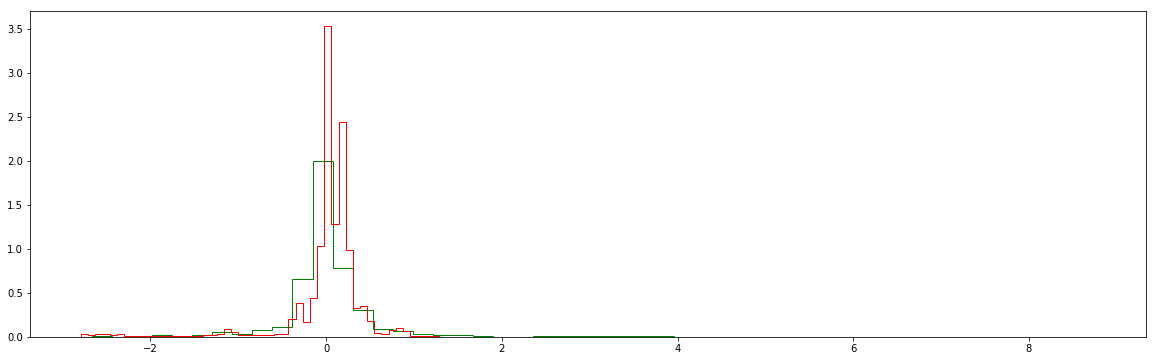

In [0]:
# PDF of train and test 'y' values. 
import matplotlib.pyplot as plt 
plt.figure(figsize=(20,6))
plt.hist(train_y, bins=50, normed=1, color='green', histtype ='step');
plt.hist(test_y, bins=50, normed=1, color='red', histtype ='step');
plt.show()




In [0]:
#Model 0: Base line Model: y_test_pred = mean(y_train_i) 
train_mean_y = np.mean(train_y)

print('Test_MSE(MEAN):%f' % np.mean(np.square(test_y-train_mean_y)) )

print('Test_MSE(ZERO):%f' % np.mean(np.square(test_y-0.0)) )


Test_MSE(MEAN):0.191127
Test_MSE(ZERO):0.190891


## Modelling

In [0]:
import scipy.misc
import random
import cv2
import tensorflow as tf
import scipy

import os
from tensorflow.core.protobuf import saver_pb2

import numpy as np

import math
sess_test = None

In [0]:
xs = []
ys = []

#read data.txt
with open("Autopilot-TensorFlow-master/Autopilot-TensorFlow-master/driving_dataset/data.txt") as f:
    for line in f:
        xs.append("Autopilot-TensorFlow-master/Autopilot-TensorFlow-master/driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)


train_xs = xs[:int(len(xs) * 0.8)]
train_ys = ys[:int(len(xs) * 0.8)]

val_xs = xs[-int(len(xs) * 0.2):]
val_ys = ys[-int(len(xs) * 0.2):]

num_train_images = len(train_xs)
num_val_images = len(val_xs)

In [0]:
#points to the end of the last batch
train_batch_pointer = 0
val_batch_pointer = 0

def LoadTrainBatch(batch_size):
    global train_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(train_xs[(train_batch_pointer + i) % num_train_images])[-150:], [66, 200])/ 255.0)
        y_out.append([train_ys[(train_batch_pointer + i) % num_train_images]])
    train_batch_pointer += batch_size
    return x_out, y_out

def LoadValBatch(batch_size):
    global val_batch_pointer
    x_out = []
    y_out = []
    for i in range(0, batch_size):
        x_out.append(scipy.misc.imresize(scipy.misc.imread(val_xs[(val_batch_pointer + i) % num_val_images])[-150:], [66, 200])/ 255.0)
        y_out.append([val_ys[(val_batch_pointer + i) % num_val_images]])
    val_batch_pointer += batch_size
    return x_out, y_out


In [0]:
LOGDIR = './save'

sess=None

def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1)
  # initial = tf.contrib.layers.variance_scaling_initializer()
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, dtype=tf.float32, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W, stride):
  return tf.nn.conv2d(x, W, strides=[1, stride, stride, 1], padding='VALID')

In [0]:
tf.reset_default_graph()

x = tf.placeholder(tf.float32, shape=[None, 66, 200, 3], name='var_x')
y_ = tf.placeholder(tf.float32, shape=[None, 1], name='var_y')

x_image = x

#first convolutional layer
W_conv1 = weight_variable([5, 5, 3, 24])
b_conv1 = bias_variable([24])

h_conv1 = tf.nn.relu(conv2d(x, W_conv1, 2) + b_conv1)

#second convolutional layer
W_conv2 = weight_variable([5, 5, 24, 36])
b_conv2 = bias_variable([36])

h_conv2 = tf.nn.relu(conv2d(h_conv1, W_conv2, 2) + b_conv2)

#third convolutional layer
W_conv3 = weight_variable([5, 5, 36, 48])
b_conv3 = bias_variable([48])

h_conv3 = tf.nn.relu(conv2d(h_conv2, W_conv3, 2) + b_conv3)

#fourth convolutional layer
W_conv4 = weight_variable([3, 3, 48, 64])
b_conv4 = bias_variable([64])

h_conv4 = tf.nn.relu(conv2d(h_conv3, W_conv4, 1) + b_conv4)

#fifth convolutional layer
W_conv5 = weight_variable([3, 3, 64, 64])
b_conv5 = bias_variable([64])

h_conv5 = tf.nn.relu(conv2d(h_conv4, W_conv5, 1) + b_conv5)

#FCL 1
W_fc1 = weight_variable([1152, 1164])
b_fc1 = bias_variable([1164])

h_conv5_flat = tf.reshape(h_conv5, [-1, 1152])
h_fc1 = tf.nn.relu(tf.matmul(h_conv5_flat, W_fc1) + b_fc1)

droprate = tf.placeholder(tf.float32, name='var_droprate')
h_fc1_drop = tf.nn.dropout(h_fc1, rate=droprate)

#FCL 2
W_fc2 = weight_variable([1164, 100])
b_fc2 = bias_variable([100])

h_fc2 = tf.nn.relu(tf.matmul(h_fc1_drop, W_fc2) + b_fc2)

h_fc2_drop = tf.nn.dropout(h_fc2, rate=droprate)

#FCL 3
W_fc3 = weight_variable([100, 50])
b_fc3 = bias_variable([50])

h_fc3 = tf.nn.relu(tf.matmul(h_fc2_drop, W_fc3) + b_fc3)

h_fc3_drop = tf.nn.dropout(h_fc3, rate=droprate)

#FCL 4
W_fc4 = weight_variable([50, 10])
b_fc4 = bias_variable([10])

h_fc4 = tf.nn.relu(tf.matmul(h_fc3_drop, W_fc4) + b_fc4)

h_fc4_drop = tf.nn.dropout(h_fc4, rate=droprate)

#Output
W_fc5 = weight_variable([10, 1])
b_fc5 = bias_variable([1])

# y = tf.multiply(tf.atan(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2) #scale the atan output

y = tf.matmul(h_fc4_drop, W_fc5) + b_fc5

#y = tf.multiply(tf.tanh(tf.matmul(h_fc4_drop, W_fc5) + b_fc5), 2)

In [0]:
tf.InteractiveSession._active_session_count

0

In [0]:
if sess:
  sess.close()

sess = tf.InteractiveSession()

L2NormConst = 0.001

train_vars = tf.trainable_variables()

loss = tf.reduce_mean(tf.square(tf.subtract(y_, y))) + tf.add_n([tf.nn.l2_loss(v) for v in train_vars]) * L2NormConst

train_step = tf.train.RMSPropOptimizer(1e-4).minimize(loss)
sess.run(tf.global_variables_initializer())

# create a summary to monitor cost tensor
tf.summary.scalar("loss", loss)
# merge all summaries into a single op
merged_summary_op =  tf.summary.merge_all()

saver = tf.train.Saver(write_version = saver_pb2.SaverDef.V2)

# op to write logs to Tensorboard
logs_path = './logs'
summary_writer = tf.summary.FileWriter(logs_path, graph=tf.get_default_graph())

In [0]:
%load_ext tensorboard

In [0]:
!rm logs/*
!rm save/*

In [0]:
%tensorboard --logdir logs

In [0]:
epochs = 10
batch_size = 64

# train over the dataset about 30 times
for epoch in range(epochs):
  #points to the end of the last batch
  global train_batch_pointer
  global val_batch_pointer
  train_batch_pointer = 0
  val_batch_pointer = 0
  for i in range(int(num_train_images/batch_size)):
    xs, ys = LoadTrainBatch(batch_size)
    train_step.run(feed_dict={x: xs, y_: ys, droprate: 0.5})
    if i % 100 == 0:
      xs, ys = LoadValBatch(batch_size)
      loss_value = loss.eval(feed_dict={x: xs, y_: ys, droprate: 0.0})
      print("Epoch: %d, Step: %d, Loss: %g" % (epoch, epoch * batch_size + i, loss_value))

    # write logs at every iteration
    summary = merged_summary_op.eval(feed_dict={x: xs, y_: ys, droprate: 0.0})
    summary_writer.add_summary(summary, epoch * num_train_images/batch_size + i)

    if i % batch_size == 0:
      if not os.path.exists(LOGDIR):
        os.makedirs(LOGDIR)
      checkpoint_path = os.path.join(LOGDIR, "model_epoch.ckpt".format(epoch))
      
      filename = saver.save(sess, checkpoint_path)
  print("Model saved in file: %s" % filename)

print("Run the command line:\n" \
          "--> tensorboard --logdir=./logs " \
          "\nThen open http://0.0.0.0:6006/ into your web browser")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Epoch: 0, Step: 0, Loss: 6.33685
Epoch: 0, Step: 100, Loss: 6.66559
Epoch: 0, Step: 200, Loss: 6.39328
Epoch: 0, Step: 300, Loss: 5.31731
Epoch: 0, Step: 400, Loss: 4.29176
Epoch: 0, Step: 500, Loss: 3.54892
Model saved in file: ./save/model_epoch.ckpt
Epoch: 1, Step: 64, Loss: 3.22073
Epoch: 1, Step: 164, Loss: 3.11916
Epoch: 1, Step: 264, Loss: 2.70255
Epoch: 1, Step: 364, Loss: 2.03539
Epoch: 1, Step: 464, Loss: 1.47436
Epoch: 1, Step: 564, Loss: 1.10593
Model saved in file: ./save/model_epoch.ckpt
Epoch: 2, Step: 128, Loss: 1.01791
Epoch: 2, Step: 228, Loss: 1.26775
Epoch: 2, Step: 328, Loss: 1.16727
Epoch: 2, Step: 428, Loss: 0.791873
Epoch: 2, Step: 528, Loss: 0.494442
Epoch: 2, Step: 628, Loss: 0.327074
Model saved in file: ./save/model_epoch.ckpt
Epoch: 3, Step: 192, Loss: 0.341187
Epoch: 3, Step: 292, Loss: 0.722081
Epoch: 3, Step: 392, Loss: 0.746922
Epoch: 3, Step: 492, Loss: 0.491145
Epoch: 3, Step: 592, Loss: 0.288657
Epoch: 3, Step: 692, Loss: 0.176765
Model saved in file

In [0]:
saver = tf.train.Saver()

save_path = saver.save(sess, "/model.ckpt")
print("Model saved in path: %s" % save_path)

Model saved in path: /model.ckpt


In [0]:
from google.colab import files
import os

In [0]:
for f in os.listdir('save/'):
  files.download(os.path.join('save', f))

In [17]:
img = scipy.misc.imread('Autopilot-TensorFlow-master/Autopilot-TensorFlow-master/steering_wheel_image.jpg', 1)
rows,cols = img.shape

#read data.txt
xs = []
ys = []
with open("Autopilot-TensorFlow-master/Autopilot-TensorFlow-master/driving_dataset/data.txt") as f:
    for line in f:
        xs.append("Autopilot-TensorFlow-master/Autopilot-TensorFlow-master/driving_dataset/" + line.split()[0])
        #the paper by Nvidia uses the inverse of the turning radius,
        #but steering wheel angle is proportional to the inverse of turning radius
        #so the steering wheel angle in radians is used as the output
        ys.append(float(line.split()[1]) * scipy.pi / 180)

#get number of images
num_images = len(xs)

# if sess:
#   sess.close()
# sess = tf.InteractiveSession()
# saver = tf.train.Saver()
# saver.restore(sess, "save/model_epoch_5.ckpt")

smoothed_angle = 0

i = math.ceil(num_images*0.8)
print("Starting frame of video:" +str(i))

while(i<num_images): # while(cv2.waitKey(10) != ord('q')):
    full_image = scipy.misc.imread("Autopilot-TensorFlow-master/Autopilot-TensorFlow-master/driving_dataset/" + str(i) + ".jpg")
    image = scipy.misc.imresize(full_image[-150:], [66, 200]) / 255.0
    degrees = y.eval(feed_dict={ x: [image], droprate: 0.0 })[0][0] * 180.0 / scipy.pi
    
    print("Steering angle: " + str(degrees) + " (pred)\t" + str(ys[i]* 180.0 / scipy.pi) + " (actual)")
    # cv2.imshow("frame", cv2.cvtColor(full_image, cv2.COLOR_RGB2BGR))
    
    #make smooth angle transitions by turning the steering wheel based on the difference of the current angle
    #and the predicted angle
    smoothed_angle += 0.2 * pow(abs((degrees - smoothed_angle)), 2.0 / 3.0) * (degrees - smoothed_angle) / abs(degrees - smoothed_angle)
    
    M = cv2.getRotationMatrix2D((cols/2,rows/2),-smoothed_angle,1)
    dst = cv2.warpAffine(img,M,(cols,rows))
    
    # cv2.imshow("steering wheel", dst)
    
    i += 1

# cv2.destroyAllWindows()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


Starting frame of video:36325
Steering angle: 17.59391331133982 (pred)	-10.79 (actual)
Steering angle: 17.86667350074969 (pred)	-10.08 (actual)
Steering angle: 17.86145352867651 (pred)	-9.380000000000003 (actual)
Steering angle: 18.185472580260036 (pred)	-7.559999999999999 (actual)
Steering angle: 18.4667995344364 (pred)	-5.949999999999999 (actual)
Steering angle: 18.674946134297954 (pred)	-3.23 (actual)
Steering angle: 19.062537171581376 (pred)	-0.81 (actual)
Steering angle: 19.280848800475198 (pred)	1.21 (actual)
Steering angle: 18.97616601443198 (pred)	3.4300000000000006 (actual)
Steering angle: 19.518506940193085 (pred)	4.44 (actual)
Steering angle: 19.517682194850806 (pred)	5.340000000000001 (actual)
Steering angle: 19.502039354104184 (pred)	5.75 (actual)
Steering angle: 19.724556671979446 (pred)	7.16 (actual)
Steering angle: 19.72183825668978 (pred)	8.27 (actual)
Steering angle: 19.337346417742253 (pred)	9.48 (actual)
Steering angle: 19.198229124727433 (pred)	0.0 (actual)
Steerin